In [ ]:
%%HTML
<style>
    body {
        --vscode-font-family: "ComicSansMS"
    }
</style>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Testing out LDO_functions.py

In [ ]:
## Calling the function from LDO_functions.py
from LDO_functions import estimate_amplifier_stages, estimate_GBW_stages
# Test the functions using available variables
csv_file = "sf_nmos_char_vg_1_3.csv"
PSRR_target_dB = -40
f_bw = 1e6
I_load = 10e-3
PM_target = 60
C_load = 11.4e-12
kgm_max = 25
I_budget = (5/100) * I_load  # 5% of I_load

In [ ]:
GBW_stage1, GBW_stage2 = estimate_GBW_stages(PSRR_target_dB, f_bw, PM_target, C_load)

print(f"Estimated GBW_stage1: {GBW_stage1*1e-9:.2f} GHz")
print(f"Estimated GBW_stage2: {GBW_stage2*1e-9:.2f} GHz")

In [ ]:
# Estimate amplifier stages using the current test parameters
result_test = estimate_amplifier_stages(csv_file, GBW_stage1, GBW_stage2, C_load, kgm_target=25)
print("Amplifier stages estimation (test):")
for k, v in result_test.items():
    if isinstance(v, float) or isinstance(v, np.floating):
        print(f"{k}: {v:.4e}")
    else:
        print(f"{k}: {v}")

In [ ]:
def estimate_gbw_and_amplifier_stages(PSRR_target_dB, f_bw, PM_target, C_load, csv_file, kgm_target=25):
    """
    Combines GBW estimation and amplifier stage estimation.

    Returns:
        result: dict containing GBW_stage1, GBW_stage2, and amplifier stage estimation results.
    """
    GBW_stage1, GBW_stage2 = estimate_GBW_stages(PSRR_target_dB, f_bw, PM_target, C_load)
    amp_result = estimate_amplifier_stages(csv_file, GBW_stage1, GBW_stage2, C_load, kgm_target=kgm_target)
    result = {
        "GBW_stage1": GBW_stage1,
        "GBW_stage2": GBW_stage2,
        "amplifier_stages": amp_result
    }
    return result

In [ ]:
## Calling the function from LDO_functions.py
from LDO_functions import estimate_amplifier_stages, estimate_GBW_stages, estimate_gbw_and_amplifier_stages
# Test the functions using available variables
csv_file = "sf_nmos_char_vg_1_3.csv"
PSRR_target_dB = -40
f_bw = 1e6
I_load = 10e-3
PM_target = 60
C_load = 11.4e-12
kgm_max = 25
I_budget = (5/100) * I_load  # 5% of I_load

In [ ]:
# Test the combined GBW and amplifier stage estimation function
result_combined = estimate_gbw_and_amplifier_stages(
    PSRR_target_dB, f_bw, PM_target, C_load, csv_file, kgm_target=kgm_max
)
print("Combined GBW and amplifier stage estimation:")
for key, value in result_combined.items():
    print(f"{key}: {value}")

In [ ]:

PSRR_sweep = np.arange(-50, 1, 5)
I_budget = (5/100) * I_load  # 5% of I_load
I_total_list = []

for psrr in PSRR_sweep:
    result = estimate_gbw_and_amplifier_stages(
        psrr, f_bw, PM_target, C_load, csv_file, kgm_target=kgm_max
    )
    I_total = result['amplifier_stages']['I_req_total']
    I_total_list.append(I_total)

# Find the PSRR value where I_total crosses I_budget
I_total_arr = np.array(I_total_list)
cross_idx = np.where(I_total_arr < I_budget)[0]
plt.figure(figsize=(7, 4))
plt.plot(PSRR_sweep, I_total_list, marker='o')
plt.hlines(I_budget, xmin=PSRR_sweep.min(), xmax=PSRR_sweep.max(), color='r', linestyle='--', label='I_budget (5% of I_load)')

if len(cross_idx) > 0:
    idx = cross_idx[0]
    psrr_cross = PSRR_sweep[idx]
    I_cross = I_total_arr[idx]
    plt.scatter(psrr_cross, I_cross, color='red', zorder=5)
    plt.annotate(f'PSRR={psrr_cross} dB\nI_total={I_cross*1e3:.2f} mA',
                    (psrr_cross, I_cross),
                    textcoords="offset points", xytext=(10,10), ha='left', color='black')

plt.legend()
plt.xlabel('PSRR Target (dB)')
plt.yscale('log')
plt.ylabel('Total Required Current (A)')
plt.title('I_total vs PSRR Target for I_load=10mA')
plt.grid(True)
plt.show()


In [ ]:
# Extract I_req_stage1 and I_req_stage2 from each result in I_total_list sweep
I_stage1_list = []
I_stage2_list = []

for psrr in PSRR_sweep:
    result = estimate_gbw_and_amplifier_stages(
        psrr, f_bw, PM_target, C_load, csv_file, kgm_target=kgm_max
    )
    I_stage1 = result['amplifier_stages']['I_req_stage1']
    I_stage2 = result['amplifier_stages']['I_req_stage2']
    I_stage1_list.append(I_stage1)
    I_stage2_list.append(I_stage2)

I_stage1_arr = np.array(I_stage1_list)
I_stage2_arr = np.array(I_stage2_list)

plt.figure(figsize=(7, 4))
plt.plot(PSRR_sweep, I_stage1_arr, marker='o', label='I_stage1')
plt.plot(PSRR_sweep, I_stage2_arr, marker='s', label='I_stage2')
plt.hlines(I_budget, xmin=PSRR_sweep.min(), xmax=PSRR_sweep.max(), color='r', linestyle='--', label='I_budget (5% of I_load)')
plt.yscale('log')
plt.xlabel('PSRR Target (dB)')
plt.ylabel('Stage Current (A)')
plt.title('I_stage1 and I_stage2 vs PSRR Target for I_load=10mA')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
I_load = 10e-3
I_res_div = (1/100) * I_load
pmos_pass_char_csv = 'ldo_pmos_kgm_char_Msweep_10mA.csv'
V_out = 1.2
V_ctrl = 0.9
f_bw = 1e6
C_load = 100e-12

In [ ]:
from LDO_functions import estimate_pass_pmos_parameters 

In [ ]:
# Test for estimate_pass_pmos_parameters using available variables

# Define test parameters
csv_file_pmos = pmos_pass_char_csv  # 'ldo_pmos_kgm_char_Msweep_10mA.csv'
I_load_test = I_load                # 0.01 (10 mA)
I_res_div_test = I_res_div          # 0.0001 (1% of I_load)
Vout_LDO_test = V_out               # 1.2 V
Vctrl_test = V_ctrl                 # 0.9 V
f_bw_test = f_bw                    # 1e6 Hz
C_out_test = C_load                 # 1.14e-11 F

# Call the function
C_in_pass_test, Av_pass_test, k_res_div_test, details_pass = estimate_pass_pmos_parameters(
    csv_file_pmos, I_load_test, I_res_div_test, Vout_LDO_test, Vctrl_test, f_bw_test, C_out_test
)

print(f"Estimated PMOS pass input capacitance (C_in_pass): {C_in_pass_test*1e12:.3f} pF")
print(f"Estimated Av_pass: {Av_pass_test:.2f} V/V")
print(f"Estimated k_res_div: {k_res_div_test:.3f}")
print("Details at selected operating point:", details_pass)

In [ ]:
## Calling the function from LDO_functions.py
from LDO_functions import estimate_amplifier_stages, estimate_GBW_stages, estimate_gbw_and_amplifier_stages, estimate_pass_pmos_parameters
# Test the functions using available variables
csv_file = "sf_nmos_char_vg_1_3.csv"
PSRR_target_dB = -40
f_bw = f_bw
I_load = 10e-3
PM_target = 60
C_load = C_in_pass_test
kgm_max = 25
I_budget = (5/100) * I_load  # 5% of I_load

In [ ]:
# Test the combined GBW and amplifier stage estimation function
result_combined = estimate_gbw_and_amplifier_stages(
    PSRR_target_dB, f_bw, PM_target, C_load, csv_file, kgm_target=kgm_max
)
print("Combined GBW and amplifier stage estimation:")
for key, value in result_combined.items():
    print(f"{key}: {value}")

# Streamlined LDO Power Consumption estimation

In [ ]:
## Calling the function from LDO_functions.py
from LDO_functions import estimate_amplifier_stages, estimate_GBW_stages, estimate_gbw_and_amplifier_stages, estimate_pass_pmos_parameters


I_load = 10e-3
I_res_div = (1/100) * I_load
pmos_pass_char_csv = 'ldo_pmos_kgm_char_Msweep_10mA.csv'
V_out = 1.2
V_ctrl = 0.9
f_bw = 1e6
C_load = 100e-12
PSRR_target_dB = -40
PM_target = 60
kgm_max = 25
I_budget = (5/100) * I_load  # 5% of I_load

# Call the function
C_in_pass_test, Av_pass_test, k_res_div_test, details_pass = estimate_pass_pmos_parameters(
    csv_file_pmos, I_load_test, I_res_div_test, Vout_LDO_test, Vctrl_test, f_bw_test, C_out_test
)

print(f"Estimated PMOS pass input capacitance (C_in_pass): {C_in_pass_test*1e12:.3f} pF")
print(f"Estimated Av_pass: {Av_pass_test:.2f} V/V")
print(f"Estimated k_res_div: {k_res_div_test:.3f}")
print("Details at selected operating point:", details_pass)


# Test the functions using available variables
csv_file = "sf_nmos_char_vg_1_3.csv"
C_load = C_in_pass_test

# Test the combined GBW and amplifier stage estimation function
result_combined = estimate_gbw_and_amplifier_stages(
    PSRR_target_dB, f_bw, PM_target, C_load, csv_file, kgm_target=kgm_max
)
print("Combined GBW and amplifier stage estimation:")
for key, value in result_combined.items():
    print(f"{key}: {value}")

In [47]:
def estimate_ldo_power_and_pass_params(
    PSRR_target_dB, f_bw, PM_target, I_load, I_res_div, V_out, V_ctrl, C_out, 
    csv_file_nmos, csv_file_pmos, kgm_target=25
):
    """
    Combines PMOS pass device estimation and amplifier stage power estimation.

    Returns:
        result: dict containing PMOS pass parameters and amplifier stage estimation results.
    """
    # Estimate PMOS pass device parameters
    C_in_pass, Av_pass, k_res_div, details_pass = estimate_pass_pmos_parameters(
        csv_file_pmos, I_load, I_res_div, V_out, V_ctrl, f_bw, C_out
    )
    # Use C_in_pass as C_load for amplifier stage estimation
    GBW_stage1, GBW_stage2 = estimate_GBW_stages(PSRR_target_dB, f_bw, PM_target, C_in_pass)
    amp_result = estimate_amplifier_stages(csv_file_nmos, GBW_stage1, GBW_stage2, C_in_pass, kgm_target=kgm_target)
    result = {
        "C_in_pass": C_in_pass,
        "Av_pass": Av_pass,
        "k_res_div": k_res_div,
        "details_pass": details_pass,
        "GBW_stage1": GBW_stage1,
        "GBW_stage2": GBW_stage2,
        "amplifier_stages": amp_result,
        "I_total": amp_result.get("I_req_total", None),
        "I_req1": amp_result.get("I_req_stage1", None),
        "I_req2": amp_result.get("I_req_stage2", None),
        "C_in_stage2": amp_result.get("C_in_stage2", None)
    }
    return result

In [49]:
I_load = 10e-3
I_res_div = (1/100) * I_load
pmos_pass_char_csv = 'ldo_pmos_kgm_char_Msweep_10mA.csv'
V_out = 1.2
V_ctrl = 0.9
f_bw = 1e6
C_load = 100e-12
PSRR_target_dB = -40
PM_target = 60
kgm_max = 25
I_budget = (5/100) * I_load  # 5% of I_load


In [50]:
# Test the estimate_ldo_power_and_pass_params function using available variables

result_ldo = estimate_ldo_power_and_pass_params(
    PSRR_target_dB=PSRR_target_dB,
    f_bw=f_bw,
    PM_target=PM_target,
    I_load=I_load,
    I_res_div=I_res_div,
    V_out=V_out,
    V_ctrl=V_ctrl,
    C_out=C_out_test,
    csv_file_nmos=csv_file,
    csv_file_pmos=csv_file_pmos,
    kgm_target=kgm_max
)

print("LDO Power and Pass Parameters Estimation:")
for key, value in result_ldo.items():
    print(f"{key}: {value}")

Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: 12000.00 Ohms
Total current through the PMOS pass transistor (I_total): 10.10 mA
Effective Load Resistance (R_L_eff) considering Rds: 287.09 Ohms
Effective Load Capacitance at I_min: 100.406 pF
Load Resistance (R_L) required for bandwidth target 1000000.0 Hz: 1585.12 Ohms
Using Resistor Divider Resistance (R_res_div): 12000.00 Ohms
Av_pass at I_total 10.10 mA: 24.53 V/V
Stage 2 required current (I_req_stage2): 0.9504 mA
Stage 2 input capacitance (C_in_stage2): 907.60 pF
Stage 1 required current (I_req_stage1): 210.7142 mA
Total required current (I_req_total): 211.6646 mA
LDO Power and Pass Parameters Estimation:
C_in_pass: 1.0916659361100337e-11
Av_pass: 24.533791468811994
k_res_div: 0.75
details_pass: {'idx_both': 37, 'M_scale_both': np.float64(888.6238), 'gm_p_both': 0.08545695121176254, 'gds_p_both': 0.00339990126252592, 'Av_pass': 24.533791468811994, 'cgs_p_both': 9.584087714018672e-13, 'cgd_p_both': 3.900028

Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: 60000.00 Ohms
Total current through the PMOS pass transistor (I_total): 2.02 mA
Effective Load Resistance (R_L_eff) considering Rds: 1435.45 Ohms
Effective Load Capacitance at I_min: 100.081 pF
Load Resistance (R_L) required for bandwidth target 1000000.0 Hz: 1590.26 Ohms
Using Resistor Divider Resistance (R_res_div): 60000.00 Ohms
Av_pass at I_total 2.02 mA: 24.53 V/V
Stage 2 required current (I_req_stage2): 0.6011 mA
Stage 2 input capacitance (C_in_stage2): 574.02 pF
Stage 1 required current (I_req_stage1): 1332.6736 mA
Total required current (I_req_total): 1333.2747 mA
Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: 60000.00 Ohms
Total current through the PMOS pass transistor (I_total): 2.02 mA
Effective Load Resistance (R_L_eff) considering Rds: 1435.45 Ohms
Effective Load Capacitance at I_min: 100.081 pF
Load Resistance (R_L) required for bandwidth target 1000000.0 Hz: 1590.26 Ohms


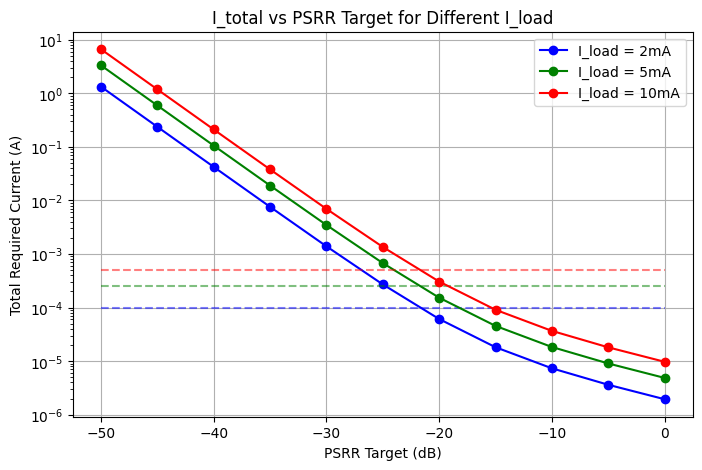

In [52]:
I_load_values = [2e-3, 5e-3, 10e-3]
colors = ['b', 'g', 'r']
labels = ['I_load = 2mA', 'I_load = 5mA', 'I_load = 10mA']

plt.figure(figsize=(8, 5))
for I_load_val, color, label in zip(I_load_values, colors, labels):
    I_budget_val = 0.05 * I_load_val
    I_total_list = []
    for psrr in PSRR_sweep:
        # Estimate PMOS pass device parameters for each I_load_val
        I_res_div_val = 0.01 * I_load_val
        C_out_val = C_out_test  # Use the defined C_out_test
        V_out_val = V_out
        V_ctrl_val = V_ctrl
        # Estimate PMOS pass device
        C_in_pass, Av_pass, k_res_div, details_pass = estimate_pass_pmos_parameters(
            csv_file_pmos, I_load_val, I_res_div_val, V_out_val, V_ctrl_val, f_bw, C_out_val
        )
        # Use C_in_pass as C_load for amplifier stage estimation
        result = estimate_gbw_and_amplifier_stages(
            psrr, f_bw, PM_target, C_in_pass, csv_file, kgm_target=kgm_max
        )
        I_total = result['amplifier_stages']['I_req_total']
        I_total_list.append(I_total)
    plt.plot(PSRR_sweep, I_total_list, marker='o', color=color, label=label)
    plt.hlines(I_budget_val, xmin=PSRR_sweep.min(), xmax=PSRR_sweep.max(), color=color, linestyle='--', alpha=0.5)

plt.yscale('log')
plt.xlabel('PSRR Target (dB)')
plt.ylabel('Total Required Current (A)')
plt.title('I_total vs PSRR Target for Different I_load')
plt.legend()
plt.grid(True)
plt.show()

Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: 12000.00 Ohms
Total current through the PMOS pass transistor (I_total): 10.10 mA
Effective Load Resistance (R_L_eff) considering Rds: 287.09 Ohms
Effective Load Capacitance at I_min: 100.406 pF
Load Resistance (R_L) required for bandwidth target 1000000.0 Hz: 1585.12 Ohms
Using Resistor Divider Resistance (R_res_div): 12000.00 Ohms
Av_pass at I_total 10.10 mA: 24.53 V/V
Stage 2 required current (I_req_stage2): 3.0055 mA
Stage 2 input capacitance (C_in_stage2): 2870.08 pF
Stage 1 required current (I_req_stage1): 6663.3679 mA
Total required current (I_req_total): 6666.3734 mA
Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: 12000.00 Ohms
Total current through the PMOS pass transistor (I_total): 10.10 mA
Effective Load Resistance (R_L_eff) considering Rds: 287.09 Ohms
Effective Load Capacitance at I_min: 100.406 pF
Load Resistance (R_L) required for bandwidth target 1000000.0 Hz: 1585.12 Ohm

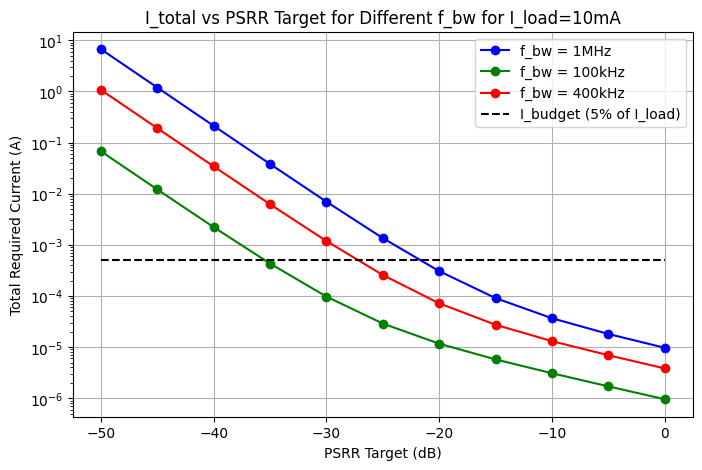

In [56]:
# Sweep I_total vs PSRR for different f_bw values
f_bw_values = [1e6, 1e5, 4e5]
f_bw_labels = ['f_bw = 1MHz', 'f_bw = 100kHz', 'f_bw = 400kHz']
colors = ['b', 'g', 'r']

plt.figure(figsize=(8, 5))
for f_bw_val, label, color in zip(f_bw_values, f_bw_labels, colors):
    I_total_list = []
    for psrr in PSRR_sweep:
        # Estimate PMOS pass device parameters for each f_bw_val
        C_in_pass, Av_pass, k_res_div, details_pass = estimate_pass_pmos_parameters(
            csv_file_pmos, I_load, I_res_div, V_out, V_ctrl, f_bw_val, C_out_test
        )
        # Use C_in_pass as C_load for amplifier stage estimation
        result = estimate_gbw_and_amplifier_stages(
            psrr, f_bw_val, PM_target, C_in_pass, csv_file, kgm_target=kgm_max
        )
        I_total = result['amplifier_stages']['I_req_total']
        I_total_list.append(I_total)
    plt.plot(PSRR_sweep, I_total_list, marker='o', color=color, label=label)

plt.hlines(I_budget, xmin=PSRR_sweep.min(), xmax=PSRR_sweep.max(), color='k', linestyle='--', label='I_budget (5% of I_load)')
plt.yscale('log')
plt.xlabel('PSRR Target (dB)')
plt.ylabel('Total Required Current (A)')
plt.title('I_total vs PSRR Target for Different f_bw for I_load=10mA')
plt.legend()
plt.grid(True)
plt.show()

Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: 12000.00 Ohms
Total current through the PMOS pass transistor (I_total): 10.10 mA
Effective Load Resistance (R_L_eff) considering Rds: 287.09 Ohms
Effective Load Capacitance at I_min: 100.406 pF
Load Resistance (R_L) required for bandwidth target 1000000.0 Hz: 1585.12 Ohms
Using Resistor Divider Resistance (R_res_div): 12000.00 Ohms
Av_pass at I_total 10.10 mA: 24.53 V/V
Stage 2 required current (I_req_stage2): 3.0055 mA
Stage 2 input capacitance (C_in_stage2): 2870.08 pF
Stage 1 required current (I_req_stage1): 6663.3679 mA
Total required current (I_req_total): 6666.3734 mA
Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: 12000.00 Ohms
Total current through the PMOS pass transistor (I_total): 10.10 mA
Effective Load Resistance (R_L_eff) considering Rds: 287.09 Ohms
Effective Load Capacitance at I_min: 100.406 pF
Load Resistance (R_L) required for bandwidth target 1000000.0 Hz: 1585.12 Ohm

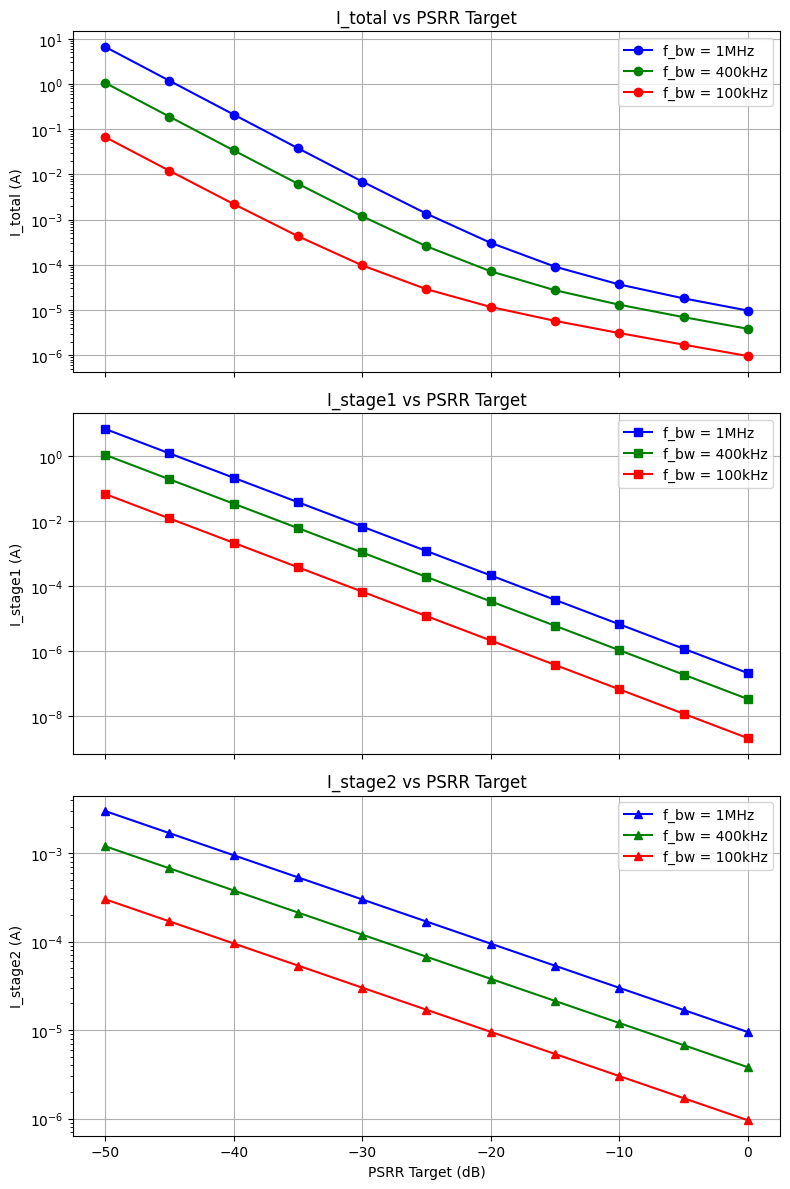

In [55]:
f_bw_values = [1e6, 0.4e6, 0.1e6]
f_bw_labels = ['f_bw = 1MHz', 'f_bw = 400kHz', 'f_bw = 100kHz']
colors = ['b', 'g', 'r']

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

for f_bw_val, label, color in zip(f_bw_values, f_bw_labels, colors):
    I_total_list = []
    I_stage1_list = []
    I_stage2_list = []
    for psrr in PSRR_sweep:
        # Estimate PMOS pass device parameters for each f_bw_val
        C_in_pass, _, _, _ = estimate_pass_pmos_parameters(
            csv_file_pmos, I_load, I_res_div, V_out, V_ctrl, f_bw_val, C_out_test
        )
        # Use C_in_pass as C_load for amplifier stage estimation
        result = estimate_gbw_and_amplifier_stages(
            psrr, f_bw_val, PM_target, C_in_pass, csv_file, kgm_target=kgm_max
        )
        I_total = result['amplifier_stages']['I_req_total']
        I_stage1 = result['amplifier_stages']['I_req_stage1']
        I_stage2 = result['amplifier_stages']['I_req_stage2']
        I_total_list.append(I_total)
        I_stage1_list.append(I_stage1)
        I_stage2_list.append(I_stage2)
    axs[0].plot(PSRR_sweep, I_total_list, marker='o', color=color, label=label)
    axs[1].plot(PSRR_sweep, I_stage1_list, marker='s', color=color, label=label)
    axs[2].plot(PSRR_sweep, I_stage2_list, marker='^', color=color, label=label)

axs[0].set_yscale('log')
axs[0].set_ylabel('I_total (A)')
axs[0].set_title('I_total vs PSRR Target')
axs[0].grid(True)
axs[0].legend()

axs[1].set_yscale('log')
axs[1].set_ylabel('I_stage1 (A)')
axs[1].set_title('I_stage1 vs PSRR Target')
axs[1].grid(True)
axs[1].legend()

axs[2].set_yscale('log')
axs[2].set_xlabel('PSRR Target (dB)')
axs[2].set_ylabel('I_stage2 (A)')
axs[2].set_title('I_stage2 vs PSRR Target')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()